In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from astropy import constants as cst
from astropy import units as u
import healpy as hp

from aqn import *
from constants import *
from survey_parameters import *
from skymap_plotting_functions import *
from aqn_simulation import *

from scipy.fft import fftn, ifftn, fftshift, ifftshift

import sys
sys.path.append('../analysis')

# from mcmc_models import *

import logging

from notebook_functions import *

2024-10-13 19:33:37,656 - debug_logger - DEBUG - This is a debug message


Loaded constants script
Loaded AQN script
Loaded survey parameters script


In [25]:
def compute_f_aqn(cubes, m_aqn_kg):

    R_aqn_cm = calc_R_AQN(m_aqn_kg)
    
    # cubes["dark_mat"] = (cubes["dark_mat"] / m_aqn_kg).to(1/u.cm**3)
    
    # compute T_AQN
    # cubes["t_aqn_n"] = T_AQN_analytical(cubes["neut_gas"], cubes["dv_neut"], f, g)
    cubes["t_aqn_i"] = T_AQN_ionized2(  cubes["ioni_gas"], cubes["dv_ioni"], f, g, 
                                        cubes["temp_ion"], R_aqn_cm)
    # # if ioni temp is lower than neut temp, replace with neut temp
    # cubes["t_aqn_i"][cubes["t_aqn_i"]<cubes["t_aqn_n"]] = \
    # cubes["t_aqn_n"][cubes["t_aqn_i"]<cubes["t_aqn_n"]]
    
    # from erg/s/Hz/cm2 to photons/s/A/cm2
    skymap_units =  1*u.photon / u.cm**2 / u.s / u.Angstrom
    def to_skymap_units(F_erg_hz_cm2,nu):
        erg_hz_cm2 = 1*u.erg/u.s/u.Hz/u.cm**2
        w = nu.to(u.AA, equivalencies=u.spectral())
        C = (erg_hz_cm2).to(skymap_units, u.spectral_density(w))
        return F_erg_hz_cm2 * C / erg_hz_cm2 * 2*np.pi

    cubes["aqn_emit"] = np.zeros(np.shape(cubes["t_aqn_i"])) * skymap_units / u.sr
    
    for nu in frequency_band:
        cubes["aqn_emit"] += to_skymap_units(spectral_surface_emissivity(nu, 
                           cubes["t_aqn_i"])/(dOmega*u.sr)*dnu/nu_range, nu)
        # cubes["aqn_emit"] += to_skymap_units(spectral_surface_emissivity(nu, 
                           # cubes["t_aqn_n"])/(dOmega*u.sr)*dnu/nu_range, nu)
        

    cubes["aqn_emit"] = cubes["aqn_emit"] * 4 * np.pi * R_aqn_cm**2 * \
                       (cubes["dark_mat"] / m_aqn_kg).to(1/u.cm**3)

    return cubes["aqn_emit"]

In [23]:
location = "/arc/projects/unions/lensing/msekatchev/"

In [ ]:
# generate FIRE cubes
fire = cube_generation()
fire.fix_rotation()
fire.prepare_particles()
fire.bin_mass_and_velocity()
fire.bin_temperature()
fire.calculate_densities()
fire.calculate_dvs()
fire.prepare_for_voronoi()
!bash ../processing/voxel-id-search.sh
fire.compute_voronoi_cubes()

2024-10-11 18:53:01,555 - debug_logger - DEBUG - >> importing FIRE simulation data


In [36]:
# load FIRE cubes
fire = cube_generation()
fire.cubes = import_cubes()

2024-10-02 15:49:49,350 - debug_logger - DEBUG - >> importing FIRE simulation data
2024-10-02 15:50:37,149 - debug_logger - DEBUG - >> imported  FIRE simulation data


In [12]:
save_class(fire, location, "fire")
fire = load_class(location, "fire")

In [4]:
import gc
gc.collect()

39

In [14]:
# specify frequency resolution and create frequency band array
# Change frequency range within survey_parameters.py
dnu = 1e14*u.Hz # 1e9 for WMAP, 1e14 for GALEX
frequency_band = np.arange(f_min_hz.value, f_max_hz.value, dnu.value) * u.Hz
nu_range = f_max_hz - f_min_hz

# This is only added for the /sr dependence of the units
dOmega = 1

In [15]:
# # m_aqn_kg = 0.01 * u.kg
# compute_f_aqn(fire.cubes, m_aqn_kg)

In [21]:
quant = {
    'dark_mat': np.array([0.3]) * u.GeV/u.cm**3 * GeV_to_g,
    'ioni_gas': np.array([0.014]) * 1/u.cm**3,
    'neut_gas': np.array([0]) * 1/u.cm**3, 
    'temp_ion': np.array([1e4]) * u.K, 
    'dv_ioni': np.array([200]) * u.km/u.s, 
    'dv_neut': np.array([200]) * u.km/u.s,
}
enforce_units(quant)

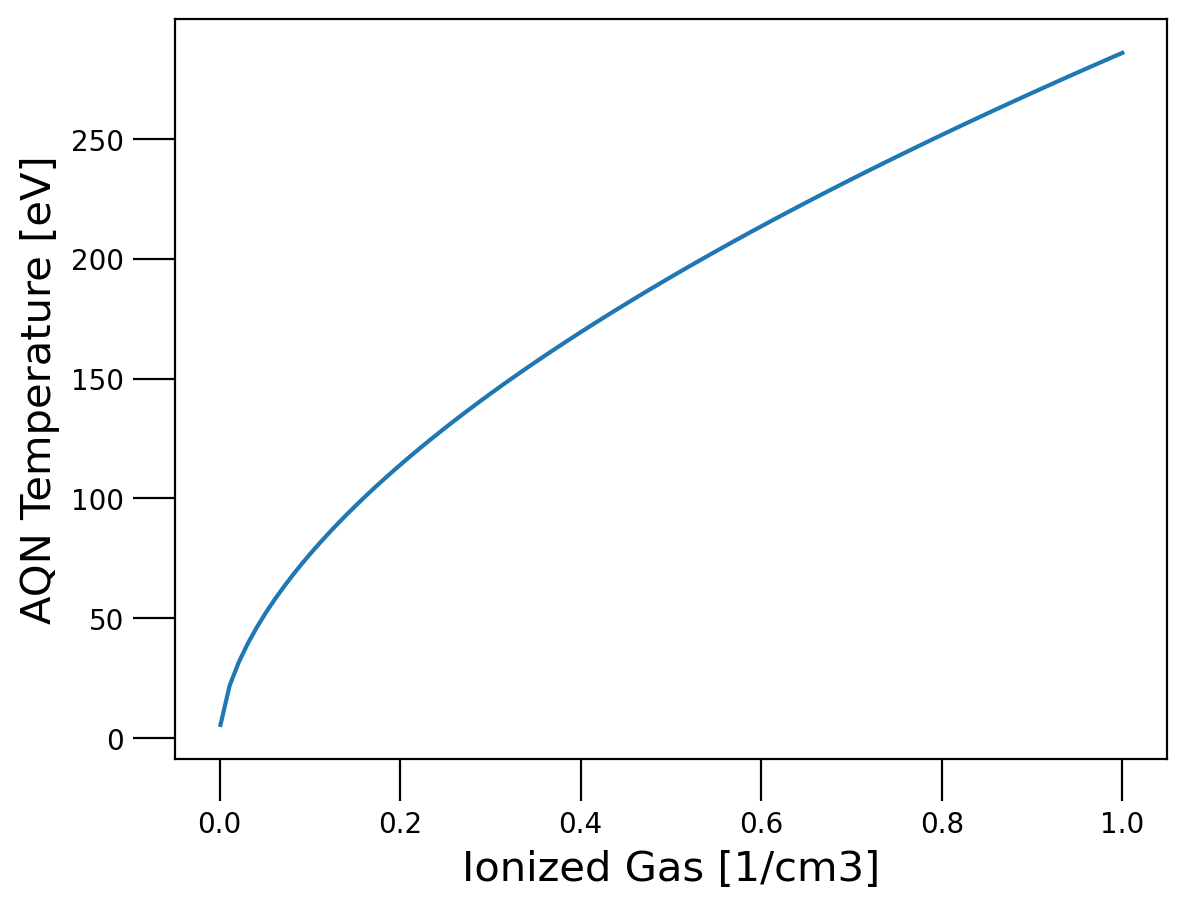

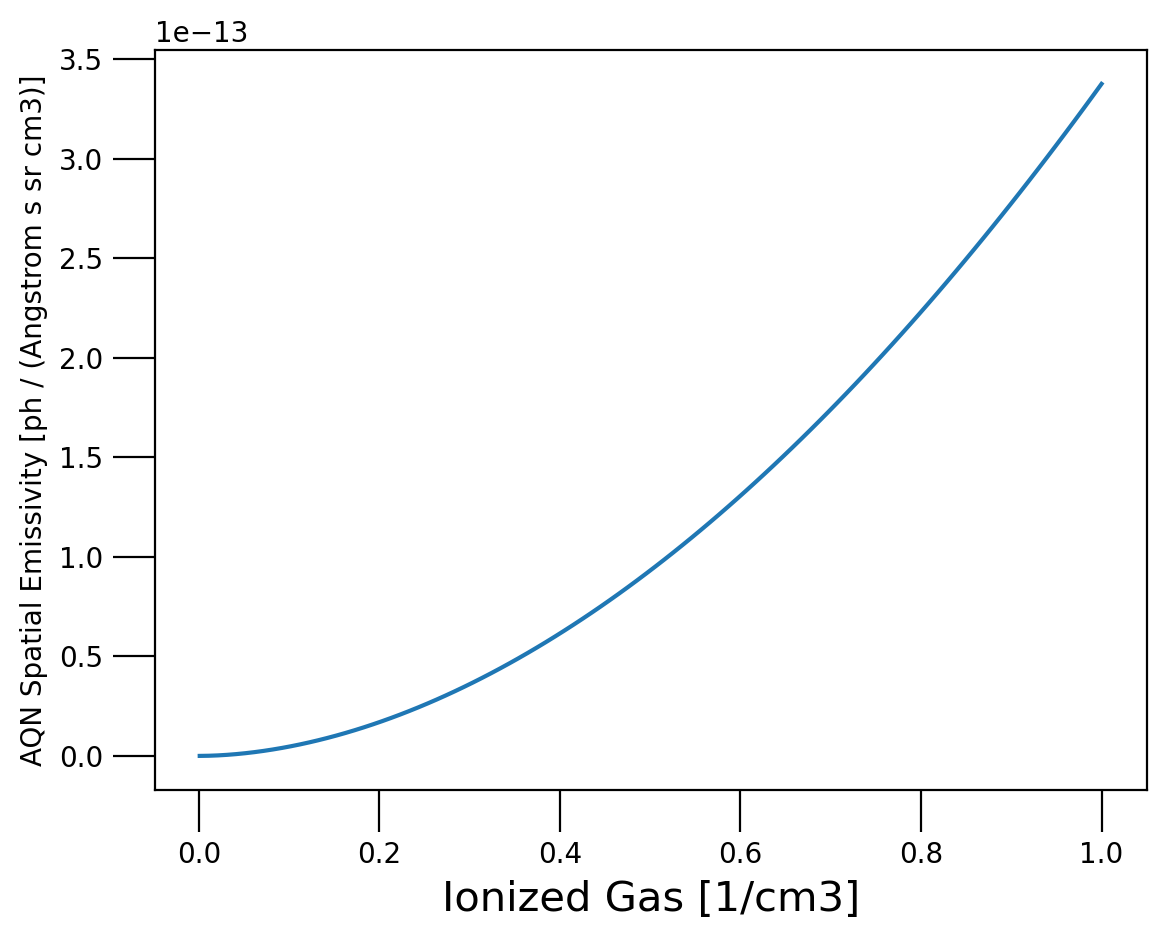

In [26]:
m_aqn_kg = 0.01 * u.kg
R_aqn_cm = calc_R_AQN(m_aqn_kg)

def plot_vary_ioni_gas(quant):
    N = 100
    ioni_gas_arr = np.linspace(0.001, 1.0, N) * 1/u.cm**3
    t_aqn_i_arr  = np.zeros(N) * u.eV
    epsilon_arr  = np.zeros(N) * compute_f_aqn(quant, m_aqn_kg).unit
    for i in range(N):
        quant["ioni_gas"] = ioni_gas_arr[i]
        epsilon_arr[i] = compute_f_aqn(quant, m_aqn_kg)
        t_aqn_i_arr[i] = quant["t_aqn_i"]

    plt.figure(dpi=200)
    plt.plot(ioni_gas_arr, t_aqn_i_arr)
    plt.xlabel("Ionized Gas [1/cm3]", size=15)
    plt.ylabel("AQN Temperature [eV]", size=15)
    plt.tick_params(size=15)
    plt.show()

    plt.figure(dpi=200)
    plt.plot(ioni_gas_arr, epsilon_arr)
    plt.xlabel("Ionized Gas [1/cm3]", size=15)
    plt.ylabel("AQN Spatial Emissivity ["+str(epsilon_arr[0].unit)+"]", size=10)
    plt.tick_params(size=15)
    plt.show()

plot_vary_ioni_gas(quant)

In [10]:
spectral_surface_emissivity(1*u.Hz, quant["t_aqn_i"])

<Quantity [2.15189169] erg / (Hz s cm2)>

In [44]:
dV = (fire.cube_length / fire.voxel_resolution)**3 # kpc

grid_coords = np.load('../data/FIRE/grid-coords.npy')

s, x, y, z = np.sqrt(grid_coords[:,0]**2 + grid_coords[:,1]**2), grid_coords[:,0], grid_coords[:,1], grid_coords[:,2]
r = np.sqrt(grid_coords[:,0]**2 + grid_coords[:,1]**2 + grid_coords[:,2]**2)
theta = np.arctan2(y, x)  # Angle in radians [-π, π]
theta = np.where(theta < 0, theta + 2 * np.pi, theta)  # Normalize to [0, 2π]

r = r.reshape((fire.voxel_resolution, fire.voxel_resolution, fire.voxel_resolution))
z = z.reshape((fire.voxel_resolution, fire.voxel_resolution, fire.voxel_resolution))
fire.cubes["aqn_emit"] = fire.cubes["aqn_emit"].reshape((fire.voxel_resolution,
                                               fire.voxel_resolution,
                                               fire.voxel_resolution))
r0 = 0.1

kernel = ((dV/(4*np.pi) * 1/r**2 * np.exp(-np.abs(z)/r0)) * u.kpc).to(u.cm)

In [45]:
def fft_convolve3d_aligned(array, kernel):
    """
    Perform a 3D convolution using FFT, ensuring that the (0,0,0) point of the 
    original array and the convolved result align.
    
    :param array: 3D numpy array representing the input data.
    :param kernel: 3D numpy array representing the kernel to convolve with.
    :return: The result of the convolution with aligned origin (0,0,0).
    """
    # Get the shape of the input array and the kernel
    array_shape = array.shape
    kernel_shape = kernel.shape
    
    # Perform FFT on both the input array and the kernel
    fft_array = fftn(array)
    
    # Shift the kernel so that its center aligns with (0,0,0) in frequency space
    fft_kernel = fftn(ifftshift(kernel), s=array_shape) # !!! why

    # Multiply in frequency domain and take inverse FFT to get the result
    convolved = ifftn(fft_array * fft_kernel)
    
    # Return the real part of the result to discard small imaginary parts
    return np.real(convolved)

aqn_emit = fft_convolve3d_aligned(fire.cubes["aqn_emit"].value, kernel)


In [46]:
lit = {}
lit["dark_mat"] = ((0.3 * u.GeV/u.cm**3)/cst.c**2).to(u.kg/u.m**3)
lit["neut_gas"] = (6.6e-24*u.g/u.cm**3).to(u.kg/u.m**3)  #(0.5 /u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["ioni_gas"] = 0.1 * lit["neut_gas"] #(0.0005/u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["ioni_gas"] = (0.1 * 1/u.cm**3 * cst.m_p).to(u.kg/u.m**3)

lit["u_dark_mat"] = ((0.1 * u.GeV/u.cm**3)/cst.c**2).to(u.kg/u.m**3)
lit["u_neut_gas"] = (0.4  /u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["u_ioni_gas"] = (0.4 /u.cm**3          *cst.m_p).to(u.kg/u.m**3)
lit["u_ioni_gas"] = (0.09/u.cm**3          *cst.m_p).to(u.kg/u.m**3)

lit["v_sun"] = (np.sqrt(11.1**2 + 12.24**2 + 7.25**2) + 232.8) * u.km/u.s # +/- 2
lit["z_sun"] = 25 * u.pc # +/- 5
lit["r_sun"] = 8.2 * u.kpc # +/- 0.1

In [47]:
X = 0.1

fire.cubes["ioni_gas"] = X * fire.cubes["neut_gas"]

compute_f_aqn(fire.cubes, m_aqn_kg)

<Quantity [[[1.92355948e-138, 1.92355948e-138, 1.92355948e-138, ...,
             7.10724980e-208, 7.10724980e-208, 7.10724980e-208],
            [1.92355948e-138, 1.92355948e-138, 1.92355948e-138, ...,
             9.30325611e-321, 7.10724980e-208, 7.10724980e-208],
            [1.92355948e-138, 1.92355948e-138, 1.92355948e-138, ...,
             9.30325611e-321, 7.10724980e-208, 3.41496144e-184],
            ...,
            [9.23193166e-136, 9.23193166e-136, 9.23193166e-136, ...,
             4.72753942e-158, 4.72753942e-158, 4.72753942e-158],
            [9.23193166e-136, 9.23193166e-136, 9.23193166e-136, ...,
             4.72753942e-158, 4.72753942e-158, 4.72753942e-158],
            [9.23193166e-136, 9.23193166e-136, 9.23193166e-136, ...,
             4.72753942e-158, 4.72753942e-158, 4.72753942e-158]],

           [[1.92355948e-138, 1.92355948e-138, 1.92355948e-138, ...,
             7.10724980e-208, 7.10724980e-208, 7.10724980e-208],
            [1.92355948e-138, 1.92355948e-1

# Integrating over v

In [8]:
# Define the function f(v) based on the Maxwell-Boltzmann distribution with a velocity shift v_b
def f_maxbolt(v, sigma_v=156, v_b=180):
    # v, sigma_v, v_b = v, sigma_v.value, v_b.value
    prefactor = 4 * np.pi * v**2 * (1 / (2 * np.pi * sigma_v**2))**(3/2)
    exponential = np.exp(-(v**2 + v_b**2) / (2 * sigma_v**2))
    
    if v_b == 0:
        return prefactor * np.exp(-v**2 / (2 * sigma_v**2))
    
    sinh_term = np.sinh(v * v_b / sigma_v**2) / (v * v_b / sigma_v**2)
    #with np.errstate(divide='ignore', invalid='ignore'):
    #    sinh_term = np.sinh(v * v_b / sigma_v**2) / (v * v_b / sigma_v**2)
    #    sinh_term[v == 0] = 1  # Handle division by zero case
    
    return prefactor * exponential * sinh_term

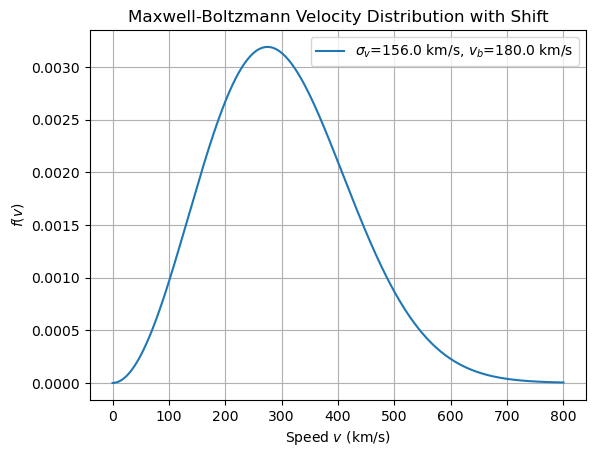

In [182]:
# Plot the distribution
sigma_v=156*u.km/u.s
v_b=180*u.km/u.s

v = np.linspace(1e-3, 800, 500) * u.km/u.s
f_v = f_maxbolt(v.value)
plt.plot(v, f_v, label=f'$\sigma_v$={sigma_v.value} km/s, $v_b$={v_b.value} km/s')

plt.xlabel('Speed $v$ (km/s)')
plt.ylabel('$f(v)$')
plt.title('Maxwell-Boltzmann Velocity Distribution with Shift')
plt.legend()
plt.grid(True)

In [125]:
quant

{'dark_mat': <Quantity [5.34798576e-22] kg / m3>,
 'ioni_gas': <Quantity [0.014] 1 / cm3>,
 'neut_gas': <Quantity [0.] 1 / cm3>,
 'temp_ion': <Quantity [0.68938666] eV>,
 'dv_ioni': <Quantity [0.00066713]>,
 'dv_neut': <Quantity [0.00066713]>}

In [9]:
def integral_function(v, quant, sigma_v, v_b, m_aqn_kg):
    f_res = f_maxbolt(v, sigma_v, v_b)
    quant_copy = quant.copy()
    quant_copy["dv_ioni"] = (v*u.km/u.s) / cst.c.to(u.km/u.s)
    quant_copy["dv_neut"] = (v*u.km/u.s) / cst.c.to(u.km/u.s)

    e_res = compute_f_aqn(quant_copy, m_aqn_kg).value

    return f_res * e_res

In [10]:
# Implement the trapezoidal rule for integration
def trapezoidal_rule(func, a, b, n, quant, sigma_v, v_b, m_aqn_kg):
    # Generate evenly spaced points from a to b
    x = np.linspace(a, b, n+1)  # n intervals gives n+1 points
    # y = func(x, quant, sigma_v, v_b, m_aqn_kg)  # Evaluate function at each point
    y = np.zeros(n+1)
    for i in range(n+1):
        y[i] = func(x[i], quant, sigma_v, v_b, m_aqn_kg) 
    
    # Compute the area using the trapezoidal rule
    h = (b - a) / n  # Width of each trapezoid
    integral = (h / 2) * (y[0] + 2 * np.sum(y[1:n]) + y[n])  # Trapezoidal rule formula
    
    return integral

# Define integration limits and number of intervals
a = 0.00001  # Start of integration
b = 800  # Upper limit; change as needed to approximate infinity
n = 100  # Number of intervals

In [198]:
result = trapezoidal_rule(integral_function, a, b, n, quant, sigma_v.value, v_b.value, m_aqn_kg)

/tmp/ipykernel_68/1159842973.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = func(x[i], quant, sigma_v, v_b, m_aqn_kg)


In [199]:
result

4.549891628434703e-23

In [128]:
quant["dv_ioni"] * cst.c.to(u.km/u.s)

<Quantity [200.] km / s>

In [154]:
quant

{'dark_mat': <Quantity [5.34798576e-22] kg / m3>,
 'ioni_gas': <Quantity [0.014] 1 / cm3>,
 'neut_gas': <Quantity [0.] 1 / cm3>,
 'temp_ion': <Quantity [0.86173333] eV>,
 'dv_ioni': <Quantity 0.00219778>,
 'dv_neut': <Quantity 0.00219778>,
 't_aqn_n': <Quantity [0.] eV>,
 't_aqn_i': <Quantity [0.00608415] eV>,
 'aqn_emit': <Quantity [0.] ph / (Angstrom s sr cm3)>}

In [252]:
def h(x):
    return_array = np.copy(x)
    return_array[np.where(x<=0)] = 0
    return_array[np.where((x<1) & (x>0))] = (17 - 12*np.log(x[np.where(x<1)]/2))
    return_array[np.where(x>=1)] = h_func_cutoff
    return return_array *10000#/ return_array

In [129]:
quant["temp_ion"] + (1/2 * (938*u.MeV).to(u.eV) * quant["dv_ioni"]**2)

<Quantity [-208.04376385] eV>

In [178]:
quant["dv_ioni"] = (180 / cst.c.to(u.km/u.s)).value

In [197]:
from scipy.integrate import quad
# Perform the integration from 0 to infinity
# result, error = quad(f_maxbolt, 0, 10000, args=(sigma_v.value, v_b.value))
result, error = quad(integral_function, 0.1, 800, args=(quant, sigma_v.value, v_b.value, m_aqn_kg))

# Print the result
print(f"Integral result: {result:.4e}, Estimated error: {error:.4e}")

Integral result: 4.2648e-23, Estimated error: 7.9111e-23


In [13]:
v = np.logspace(-3,3, 100) * u.km/u.s
res = np.zeros(len(v))
for i in range(len(v)):
    # res[i] = integral_function(v[i].value, quant, sigma_v.value, v_b.value, m_aqn_kg)
    quant_copy = quant.copy()
    quant_copy["dv_ioni"] = (v[i]*u.km/u.s) / cst.c.to(u.km/u.s)
    quant_copy["dv_neut"] = (v[i]*u.km/u.s) / cst.c.to(u.km/u.s)

    res[i] = compute_f_aqn(quant_copy, m_aqn_kg).value
    # res[i] = 
    # res[i] = integral_function(v[i].value, quant, sigma_v.value, v_b.value, m_aqn_kg) / f_maxbolt(v[i].value, sigma_v.value, v_b.value)

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

Text(0, 0.5, '$\\epsilon$')

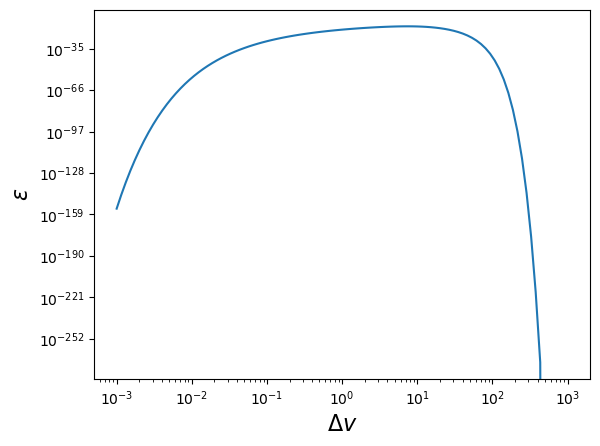

In [248]:
plt.plot(v, res)
# plt.plot(v, v**(2+13/7) * np.max(res))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Delta v$", size=16)
plt.ylabel(r"$\epsilon$", size=16)

Text(0, 0.5, '$\\epsilon$')

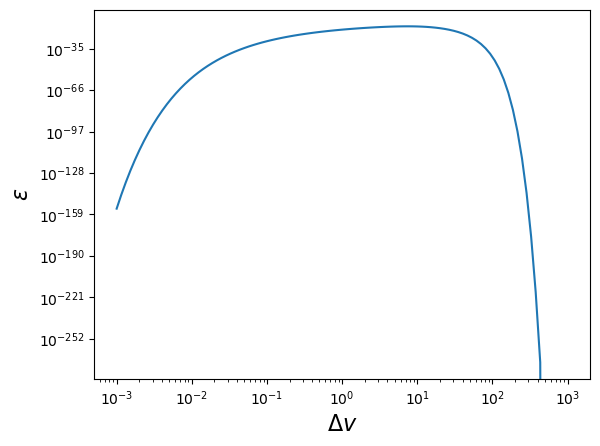

In [254]:
plt.plot(v, res)
# plt.plot(v, v**(2+13/7) * np.max(res))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$\Delta v$", size=16)
plt.ylabel(r"$\epsilon$", size=16)

In [185]:
quant["dv_ioni"] * cst.c.cgs.to(u.km/u.s)

<Quantity 800. km / s>

In [179]:
compute_f_aqn(quant, m_aqn_kg) # * (0.6*u.kpc).to(u.cm)

<Quantity [1.48094876e-77] ph / (Angstrom s sr cm3)>

In [158]:
result * (0.6*u.kpc).to(u.cm)

<Quantity 0.08423699 cm>

In [18]:
quant

{'dark_mat': <Quantity [5.34798576e-22] kg / m3>,
 'ioni_gas': <Quantity 1. 1 / cm3>,
 'neut_gas': <Quantity [0.] 1 / cm3>,
 'temp_ion': <Quantity [0.68938666] eV>,
 'dv_ioni': <Quantity [0.00066713]>,
 'dv_neut': <Quantity [0.00066713]>,
 't_aqn_n': <Quantity [0.] eV>,
 't_aqn_i': <Quantity [368.92178983] eV>,
 'aqn_emit': <Quantity [5.49463807e-11] ph / (Angstrom s sr cm3)>}